In [1]:
library(dplyr)
library(ggplot2)
library(bedr)
library(Biostrings)
library(stringr)
library(lessR)
library(SeuratDisk)
library(Seurat)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




######################
#### bedr v1.0.7 ####
######################

checking binary availability...
  * Checking path for bedtools... PASS
    /usr/local/bin/bedtools
  * Checking path for bedops... PASS
    /usr/bin/bedops
  * Checking path for tabix... PASS
    /usr/local/bin/tabix
tests and examples will be skipped on R CMD check if binaries are missing


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Fil

In [2]:
b2g_path <- "/home/ayang/projects/cat-atac/cond8/tsv/"
multiomeH5name <- "/home/jupyter-ayang/notebooks/cond8_ay/seurat_cond8.h5seurat"
barcode2guide_tsv_path <- paste0(b2g_path, "CRISPR8_ALL_STRUCTURED.TSV")
xlsname <- paste0("/home/jupyter-ayang/notebooks/cond8_ay/", "CONDITION8_PIVOT.xlsx")
tsvname <- paste0("/home/jupyter-ayang/notebooks/cond8_ay/", "CONDITION8_PIVOT.TSV")

#setwd("/home/vsevim/prj/catatac/scripts")

In [3]:
# main_path <- "/home/vsevim/prj/catatac/analysis/Test2/condition4and5"
# b2g_path <- paste0(main_path, "/barcode2guide-B/")
# multiomeH5name <- paste0(main_path, "/seurat/Condition5.h5seurat")
# barcode2guide_tsv_path <- paste0(b2g_path, "CRISPR5_ALL_STRUCTURED.TSV")
# xlsname <- paste0(b2g_path, "CONDITION5_PIVOT.xlsx")
# tsvname <- paste0(b2g_path, "CONDITION5_PIVOT.TSV")
# setwd("/home/vsevim/prj/catatac/scripts")

# main_path <- "/home/vsevim/prj/catatac/analysis/Test3/cond6/"
# b2g_path <- paste0(main_path, "guide_capture/barcode2guide/")
# multiomeH5name <- paste0(main_path, "/seurat/cond6.h5seurat")
# barcode2guide_tsv_path <- paste0(b2g_path, "CRISPR6_ALL_STRUCTURED.TSV")
# xlsname <- paste0(b2g_path, "CONDITION6_PIVOT.xlsx")
# tsvname <- paste0(b2g_path, "CONDITION6_PIVOT.TSV")

setwd("/home/vsevim/prj/catatac/scripts")

In [4]:
stats <- c()

In [5]:
barcode2guide_tsv_path

[1] "/home/ayang/projects/cat-atac/cond8/tsv/CRISPR8_ALL_STRUCTURED.TSV"

# Load and analyze guide capture

In [6]:
df_barcode2guide <-
    read.table(barcode2guide_tsv_path, header = TRUE, sep = "\t", quote = "")

df_barcode2guide <-
    data.frame(lapply(df_barcode2guide, trimws), stringsAsFactors = FALSE)

stats[["Guide-capture UMI counts"]] <- nrow(df_barcode2guide)

# Some ATAC barcodes are not associated with a GEX barcode
# I think those are just sequencing errors. I remove those from the list
select_valid_barcodes <- df_barcode2guide$barcode != ""
df_barcode2guide <- df_barcode2guide[select_valid_barcodes, ]

stats[["Guide-capture UMI counts after removing empty barcodes"]] <-
    nrow(df_barcode2guide)

# Append "-1" to the barcodes. Cellranger appends this number to distinguish
# different samples in aggregated files.
dummy  <- DNAStringSet(df_barcode2guide$barcode)
df_barcode2guide$barcode_dash <- paste0(dummy, "-1")

### Eliminate PCR duplicates of the UMIs from the same barcode

In [7]:
# I already deduplicated guide umis. No more dedup is necessary.
df_deduped <- df_barcode2guide

# df_deduped <- df_barcode2guide %>% distinct(gene, umi, .keep_all = TRUE)

stats[["Guide-capture UMI counts after removing PCR duplicates"]] <-
    nrow(df_deduped)

# dim(df_deduped)

In [8]:
head(df_deduped)

,atac_barcode,umi,protospacer,guide,gene,read_name,barcode,barcode_dash
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,GGGTTGCAGTCAATCT,TGAAATAAAGTA,GCTGACCCTGCGGGGAAGAA,GATA5_1,GATA5,A00351:759:H5G5LDSX5:4:1101:6126:1016,ACAACACTCCTCACTA,ACAACACTCCTCACTA-1
2,GTTCGTTCACAAGGCT,TGGTGTTCTATT,GCTGACCCTGCGGGGAAGAA,GATA5_1,GATA5,A00351:759:H5G5LDSX5:4:1101:9399:1016,CACAAGCGTTGGTTCT,CACAAGCGTTGGTTCT-1
3,CAGAATCAGGTATGTA,TTTATTGGGTTT,GCTGACCCTGCGGGGAAGAA,GATA5_1,GATA5,A00351:759:H5G5LDSX5:4:1101:19343:1047,GTAGCCATCGAGCTAT,GTAGCCATCGAGCTAT-1
4,CGCGATAAGTCATGAA,GTATTAGAATTG,GCTGACCCTGCGGGGAAGAA,GATA5_1,GATA5,A00351:759:H5G5LDSX5:4:1101:8196:1063,TCTCAATTCGGTTAGT,TCTCAATTCGGTTAGT-1
5,TGGGCGTAGTAACCGG,TTGCACTGTGTG,GCTGACCCTGCGGGGAAGAA,GATA5_1,GATA5,A00351:759:H5G5LDSX5:4:1101:10981:1063,TGCTTCATCCGTTAAA,TGCTTCATCCGTTAAA-1
6,TACCTGCAGTTTCTGG,CTAATACTAAAT,GCTGACCCTGCGGGGAAGAA,GATA5_1,GATA5,A00351:759:H5G5LDSX5:4:1101:4969:1078,TAAGCTATCCTAAGTA,TAAGCTATCCTAAGTA-1


# Build a df for all barcodes

Summerizing the umi counts, guide counts etc. Find the barcodes that are associated with multiple genes.

In [9]:
# Build two new dfs to summerize guide and gene counts
df_gene_counts <- pivot(df_deduped, table, gene, barcode)
df_guide_counts <- pivot(df_deduped, table, guide, barcode)

# Drop unused columns
df_gene_counts <- select(df_gene_counts, -gene_na, -gene_n)
df_barcodes <- select(df_guide_counts, -guide_na)

## Don't need to merge guides, since we want to demux by individual PS
## Merge guide and gene columns
##df_barcodes <- merge(df_gene_counts, df_guide_counts, by = "barcode")

# n_guides is umi count
df_barcodes <- dplyr:::rename(df_barcodes, n_guides = guide_n)

# Add a "-1" to barcode names to match with multiome barcode
# names from cellranger.
dummy  <- DNAStringSet(df_barcodes$barcode)
df_barcodes$barcode_dash <- paste0(dummy, "-1")


In [10]:
median(df_barcodes$n_guides)
head(df_barcodes, 10)

[1] 134

,barcode,n_guides,GATA5_1,GATA5_2,MEOX1_1,MEOX1_2,NEUROG2_1,NEUROG2_2,NTCTL_1,NTCTL_2,barcode_dash
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,AAACAGCCAAACTGCC,50,1,10,25,0,4,2,1,7,AAACAGCCAAACTGCC-1
2,AAACAGCCAAAGCCTC,193,93,14,34,0,9,20,0,23,AAACAGCCAAAGCCTC-1
3,AAACAGCCAAATGCCC,166,42,0,102,0,0,13,0,9,AAACAGCCAAATGCCC-1
4,AAACAGCCAACCGCCA,219,17,5,80,2,20,64,11,20,AAACAGCCAACCGCCA-1
5,AAACAGCCAAGCGAGC,121,8,7,36,7,17,42,0,4,AAACAGCCAAGCGAGC-1
6,AAACAGCCAATAGCAA,98,12,3,23,9,30,4,0,17,AAACAGCCAATAGCAA-1
7,AAACAGCCAATCGCAC,29,4,0,13,0,0,1,0,11,AAACAGCCAATCGCAC-1
8,AAACAGCCAATTAAGG,84,0,0,39,0,5,16,8,16,AAACAGCCAATTAAGG-1
9,AAACAGCCAATTATGC,175,35,37,62,8,0,20,13,0,AAACAGCCAATTATGC-1


Find the dominant targeted gene and calculate its percantage

In [11]:
df_gene_counts <- select(df_barcodes, GATA5_1, GATA5_2, MEOX1_1, MEOX1_2, NEUROG2_1, NEUROG2_2, NTCTL_1, NTCTL_2)
#df_gene_counts <- select(df_barcodes, GATA5, MEOX1, NEUROG2, NTCTL)
dominant_gene  <- colnames(df_gene_counts)[apply(df_gene_counts, 1, which.max)]
dominant_gene_count <- apply(df_gene_counts, 1, max)

# Dominant gene name is randomly picked if two genes
# targeted with same number of guides
df_barcodes$dominant_gene_w_caveat <- dominant_gene
df_barcodes$dominant_gene_count <- dominant_gene_count

In [12]:
head(df_barcodes)

,barcode,n_guides,GATA5_1,GATA5_2,MEOX1_1,MEOX1_2,NEUROG2_1,NEUROG2_2,NTCTL_1,NTCTL_2,barcode_dash,dominant_gene_w_caveat,dominant_gene_count
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,AAACAGCCAAACTGCC,50,1,10,25,0,4,2,1,7,AAACAGCCAAACTGCC-1,MEOX1_1,25
2,AAACAGCCAAAGCCTC,193,93,14,34,0,9,20,0,23,AAACAGCCAAAGCCTC-1,GATA5_1,93
3,AAACAGCCAAATGCCC,166,42,0,102,0,0,13,0,9,AAACAGCCAAATGCCC-1,MEOX1_1,102
4,AAACAGCCAACCGCCA,219,17,5,80,2,20,64,11,20,AAACAGCCAACCGCCA-1,MEOX1_1,80
5,AAACAGCCAAGCGAGC,121,8,7,36,7,17,42,0,4,AAACAGCCAAGCGAGC-1,NEUROG2_2,42
6,AAACAGCCAATAGCAA,98,12,3,23,9,30,4,0,17,AAACAGCCAATAGCAA-1,NEUROG2_1,30


Calculate the percantage of the dominant targeted gene

In [13]:
percent_dominant <- 100. * df_barcodes$dominant_gene_count / df_barcodes$n_guide
df_barcodes$percent_dominant_gene <- percent_dominant

Get number of targeted genes

In [14]:
df_barcodes$targeted_gene_count <- rowSums(df_gene_counts != 0)

In [15]:
head(df_gene_counts)

,GATA5_1,GATA5_2,MEOX1_1,MEOX1_2,NEUROG2_1,NEUROG2_2,NTCTL_1,NTCTL_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,10,25,0,4,2,1,7
2,93,14,34,0,9,20,0,23
3,42,0,102,0,0,13,0,9
4,17,5,80,2,20,64,11,20
5,8,7,36,7,17,42,0,4
6,12,3,23,9,30,4,0,17


# Load multiome data

In [16]:
seurat <- LoadH5Seurat(multiomeH5name)

Validating h5Seurat file

Initializing ATAC with data

Adding counts for ATAC

Adding feature-level metadata for ATAC

Adding variable feature information for ATAC

Adding miscellaneous information for ATAC

Loading required package: Signac

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Adding reduction lsi

Adding cell embeddings for lsi

Adding feature loadings for lsi

Adding miscellaneous information for lsi

Adding reduction umap.atac

Adding cell embeddings for umap.atac

Adding miscellaneous information for umap.atac

Adding reduction wnn.umap

Adding cell embeddings for wnn.umap

Adding miscellaneous information for wnn.umap

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction 

### Intersect guide-capture barcodes with multiome barcodes

In [17]:
# Find overlapping barcodes
multiome_barcodes       <- Cells(seurat)
df_barcodes$in_multiome <- df_barcodes$barcode_dash %in% multiome_barcodes

In [18]:
nrow(seurat)
length(multiome_barcodes)
head(multiome_barcodes)
nrow(seurat@meta.data)
#str(seurat)
length(Cells(seurat))

[1] 27294

[1] 15109

[1] "AAACAGCCAAAGCCTC-1" "AAACAGCCAATTATGC-1" "AAACAGCCACAGAACG-1"
[4] "AAACAGCCACATTGCA-1" "AAACAGCCACCAAAGG-1" "AAACAGCCAGGTTATT-1"

[1] 15109

[1] 15109

In [19]:
sample_n(df_barcodes, 5)

barcode,n_guides,GATA5_1,GATA5_2,MEOX1_1,MEOX1_2,NEUROG2_1,NEUROG2_2,NTCTL_1,NTCTL_2,barcode_dash,dominant_gene_w_caveat,dominant_gene_count,percent_dominant_gene,targeted_gene_count,in_multiome
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
GCGAAGTAGAGGAGGA,238,26,18,56,2,27,42,42,25,GCGAAGTAGAGGAGGA-1,MEOX1_1,56,23.52941,8,FALSE
TGGCGGTTCACATTGA,7,0,0,0,0,0,7,0,0,TGGCGGTTCACATTGA-1,NEUROG2_2,7,100.00000,1,FALSE
TTAGGCTAGTTATGGC,117,10,0,69,0,21,2,3,12,TTAGGCTAGTTATGGC-1,MEOX1_1,69,58.97436,6,FALSE
TCTACCTCATGTTGTG,111,17,2,35,6,0,14,0,37,TCTACCTCATGTTGTG-1,NTCTL_2,37,33.33333,6,FALSE
CTATTACTCACGCCAA,314,44,16,164,9,44,24,0,13,CTATTACTCACGCCAA-1,MEOX1_1,164,52.22930,7,TRUE


Write df_barcodes to TSV and XLS

In [20]:
library(writexl)
write_xlsx(df_barcodes, xlsname)
write.table(df_barcodes, tsvname, sep = "\t", quote = FALSE, row.names = FALSE)

# Produce charts

In [21]:
select_gt1_umi_per_cell <- df_barcodes$n_guides > 1
select_convergent       <- df_barcodes$targeted_gene_count == 1

df_barcodes_gt1         <- df_barcodes[select_gt1_umi_per_cell, ]
df_in_multiome          <- df_barcodes[df_barcodes$in_multiome, ]
df_gt1_in_multiome      <- df_barcodes_gt1[df_barcodes_gt1$in_multiome, ]
df_convergent           <- df_barcodes[select_convergent, ]

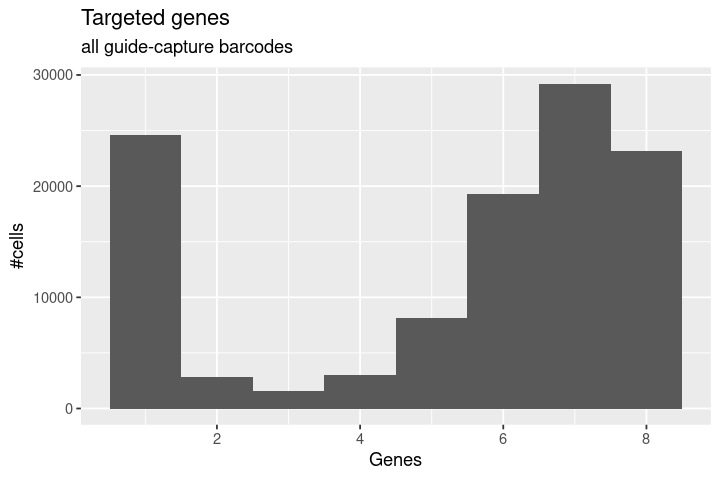

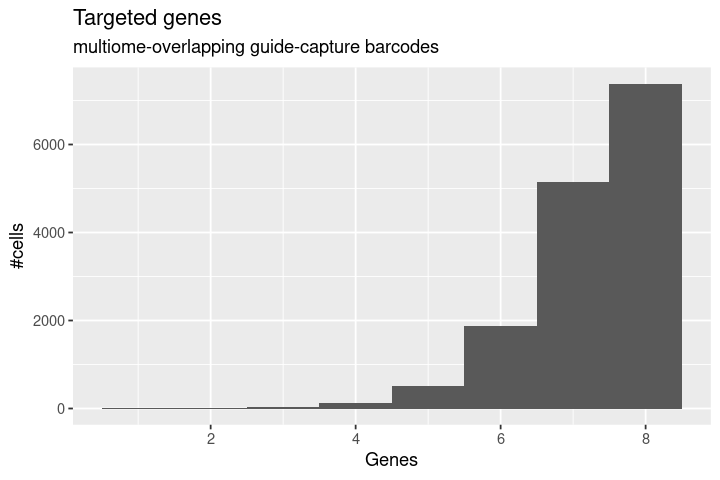

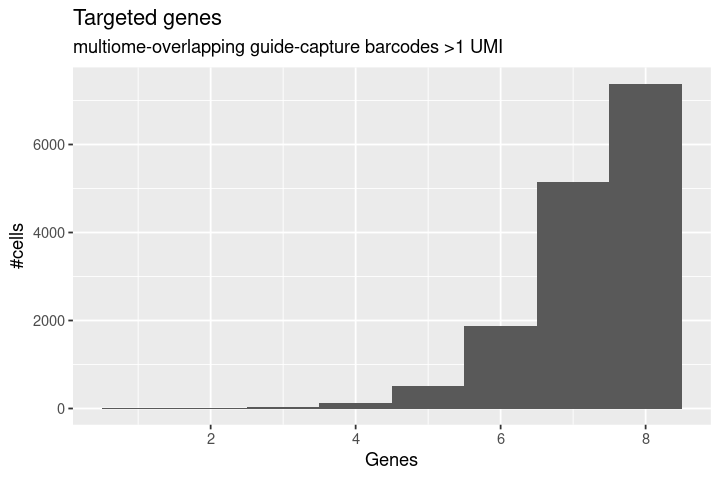

In [22]:
options(repr.plot.width = 6, repr.plot.height = 4)

ggplot(df_barcodes, aes(x=targeted_gene_count)) +
    geom_histogram(binwidth=1) +
    labs(title="Targeted genes", x="Genes")+
    labs(subtitle="all guide-capture barcodes", y="#cells") 

ggplot(df_in_multiome, aes(x=targeted_gene_count)) +
    geom_histogram(binwidth=1) +
    labs(title="Targeted genes", x="Genes")+
    labs(subtitle="multiome-overlapping guide-capture barcodes", y="#cells") 

ggplot(df_gt1_in_multiome, aes(x=targeted_gene_count)) +
    geom_histogram(binwidth=1) +
    labs(title="Targeted genes", x="Genes")+
    labs(subtitle="multiome-overlapping guide-capture barcodes >1 UMI", y="#cells") 

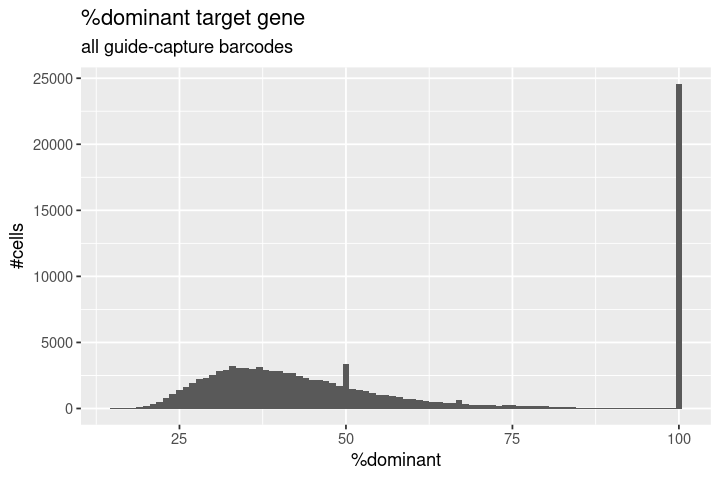

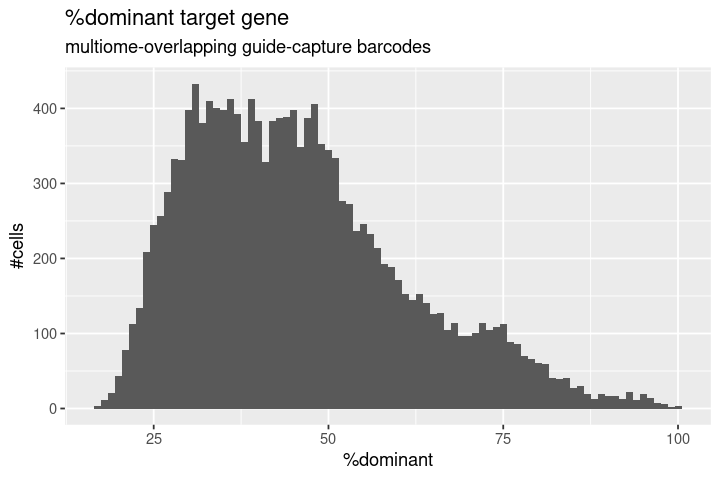

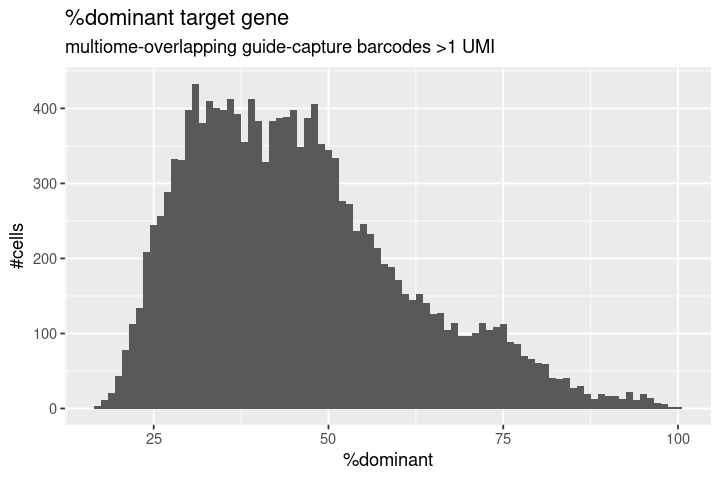

In [23]:
options(repr.plot.width = 6, repr.plot.height = 4)

ggplot(df_barcodes, aes(x=percent_dominant_gene)) +
    geom_histogram(binwidth=1) +
    labs(title="%dominant target gene", x="%dominant")+
    labs(subtitle="all guide-capture barcodes", y="#cells")

ggplot(df_in_multiome, aes(x=percent_dominant_gene)) +
    geom_histogram(binwidth=1) +
    labs(title="%dominant target gene", x="%dominant")+
    labs(subtitle="multiome-overlapping guide-capture barcodes", y="#cells")

ggplot(df_gt1_in_multiome, aes(x=percent_dominant_gene)) +
    geom_histogram(binwidth=1) +
    labs(title="%dominant target gene", x="%dominant")+
    labs(subtitle="multiome-overlapping guide-capture barcodes >1 UMI", y="#cells")

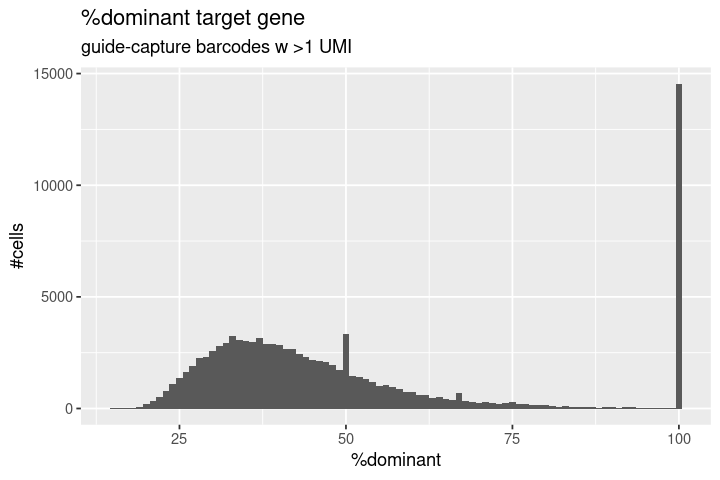

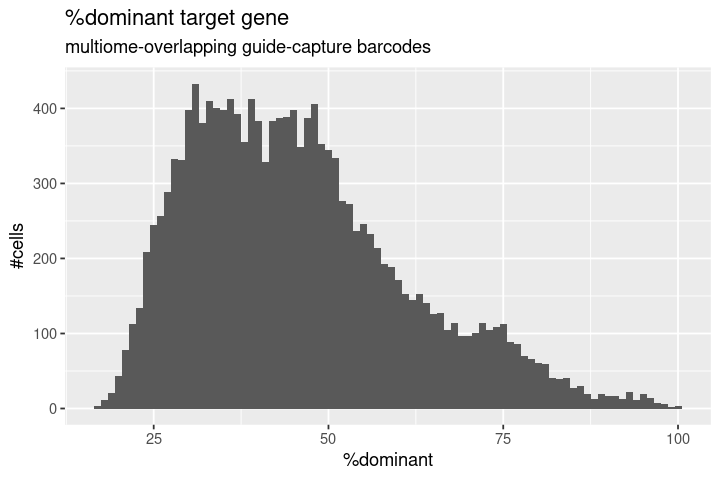

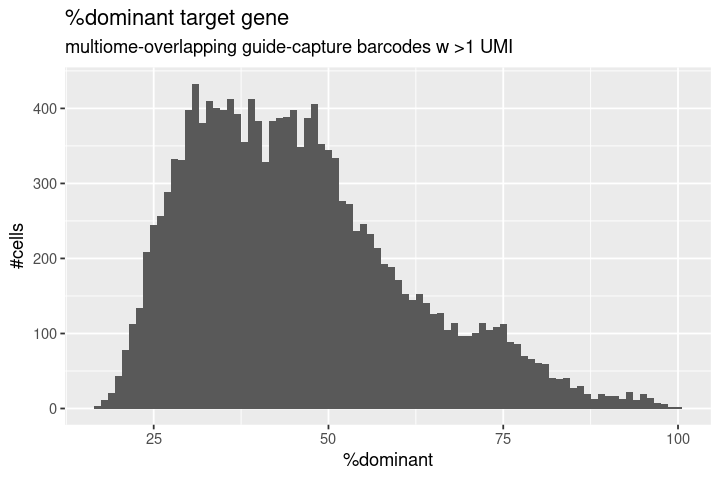

In [24]:
options(repr.plot.width = 6, repr.plot.height = 4)

ggplot(df_barcodes_gt1, aes(x = percent_dominant_gene)) +
    geom_histogram(binwidth=1) +
    labs(title="%dominant target gene", x="%dominant")+
    labs(subtitle="guide-capture barcodes w >1 UMI", y="#cells")

ggplot(df_in_multiome, aes(x = percent_dominant_gene)) +
    geom_histogram(binwidth=1) +
    labs(title="%dominant target gene", x="%dominant")+
    labs(subtitle="multiome-overlapping guide-capture barcodes", y="#cells")

ggplot(df_gt1_in_multiome, aes(x = percent_dominant_gene)) +
    geom_histogram(binwidth=1) +
    labs(title="%dominant target gene", x="%dominant")+
    labs(subtitle="multiome-overlapping guide-capture barcodes w >1 UMI", y="#cells")

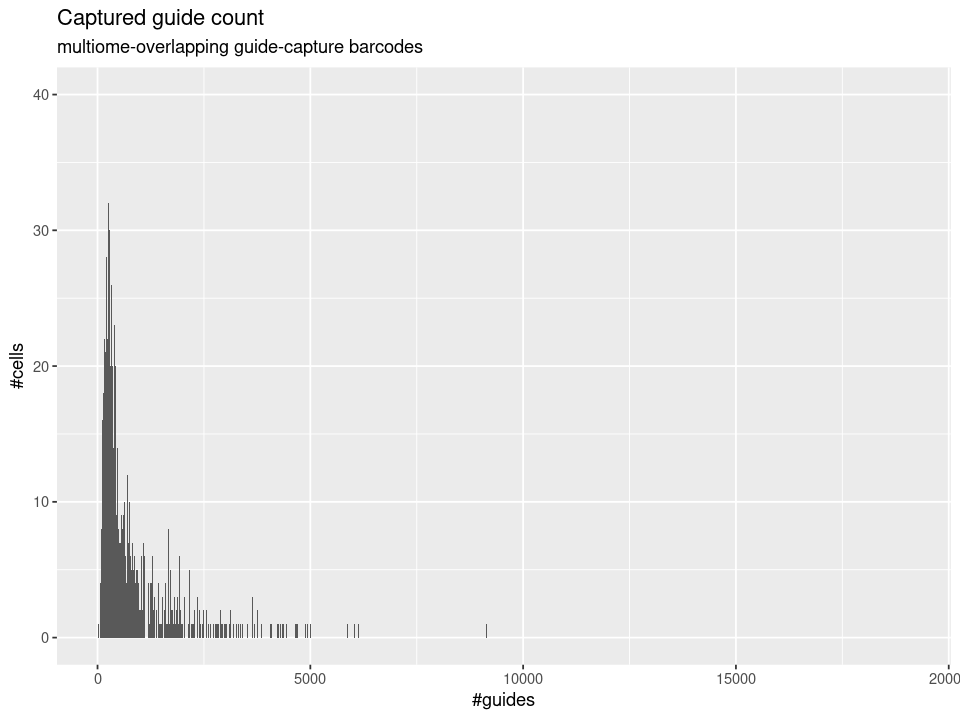

In [25]:
options(repr.plot.width = 8, repr.plot.height = 6)

ggplot(df_in_multiome, aes(x = n_guides)) +
    geom_histogram(binwidth=1) +
    labs(title = "Captured guide count", x = "#guides")+
    labs(subtitle = "multiome-overlapping guide-capture barcodes", y = "#cells")
    

In [26]:
# Record stats
stats[["%overlapping"]] <-
    100 * sum(df_barcodes$in_multiome) / length(multiome_barcodes)

stats[["Guide-capture barcodes"]] <- nrow(df_barcodes)
stats[["Multiome barcodes"]]      <- length(multiome_barcodes)
stats[["Overlapping barcodes"]]   <- sum(df_barcodes$in_multiome)
stats[["Overlapping barcodes > 1 UMI"]] <- sum(df_barcodes_gt1$in_multiome)
stats[["Guide capture all convergent"]] <- nrow(df_convergent)

stats[["Guide capture overlapping convergent"]] <-
    sum(df_convergent$in_multiome)

# Print stats

In [27]:
for (tag in names(stats)) {
    if (tag != "Capture efficiency") {
        text <- sprintf("%s\t%g\n", tag, stats[[tag]])
    }
    else {
        text <- sprintf("%s\t%.1f%%\n", tag, stats[[tag]])
    }
    cat(text)
}

Guide-capture UMI counts	2.45686e+07
Guide-capture UMI counts after removing empty barcodes	2.40079e+07
Guide-capture UMI counts after removing PCR duplicates	2.40079e+07
%overlapping	100
Guide-capture barcodes	111604
Multiome barcodes	15109
Overlapping barcodes	15109
Overlapping barcodes > 1 UMI	15108
Guide capture all convergent	24589
Guide capture overlapping convergent	3


In [28]:
round(t(as.data.frame(stats)))

Guide.capture.UMI.counts,24568624
Guide.capture.UMI.counts.after.removing.empty.barcodes,24007910
Guide.capture.UMI.counts.after.removing.PCR.duplicates,24007910
X.overlapping,100
Guide.capture.barcodes,111604
Multiome.barcodes,15109
Overlapping.barcodes,15109
Overlapping.barcodes...1.UMI,15108
Guide.capture.all.convergent,24589
Guide.capture.overlapping.convergent,3
